# Capstone Project - Wave whisperers (Group 6)



# Imports

In [198]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# Data collection and preprocessing

Data is retrieved after the previous extraction on waves and shorelines for the 20 selected sites:
- Shoreline data was retrieved using CoastSat, an open-source software toolkit that enables users to obtain time-series of shoreline position at any coastal stretch from publicly available satellite imagery.
- Wave data was extracted from the ERA5 programme dataset for meteorological and global climate reanalysis, available at the European Centre for Medium-Range Weather Forecasts (ECMWF) website.

After loading the data from the csv's, wave and shoreline data are manipulated with a loop through each site name, structuring waves_df and shorelines_df into a combined dictionary.
Regarding waves, a deeper preprocessing is required in order to convert degrees into directions and considering both height and period.

In [199]:
# Paths and site names setup
waves_folder_path = "./dataset_Ondas"
shorelines_folder_path = "./dataset_linhascosta"
transects_folder_path = "./dataset_transects"
site_names = ['CVCC','CCFT','FTAD','ADLA','LABI',
              'TRAT','ATMC','MCCO','CCCL','NNOR',
              'MEIA','TORR','CVMR','MRMG','MGVR',
              'COSN','VAGR','GBHA','BARR','MIRA']

In [200]:
# Create an empty dictionary to store DataFrames
data = {}

# Loop through each file name
for name in site_names:
    # Construct the file paths
    waves_file_path = os.path.join(waves_folder_path, f"{name}_wave_timeseries.csv")
    shorelines_file_path = os.path.join(shorelines_folder_path, f"{name}_shoreline_timeseries.csv")
    transects_file_path = os.path.join(transects_folder_path, f"{name}_T.geojson")

    # Read the waves CSV files into DataFrame
    waves_df = pd.read_csv(waves_file_path, sep=',', header=0) # Set header=0 to use the first row as column headers
    
    waves_df['time'] = pd.to_datetime(waves_df['time'])
    waves_df.set_index('time', inplace=True)

    # time column is already in datetime format and set as the index
    waves_df['years'] = waves_df.index.year
    waves_df['months'] = waves_df.index.month

    # Remove rows from January 1983 to March 1989
    waves_df = waves_df[~((waves_df.index >= '1983-01-01') & (waves_df.index <= '1989-03-31'))]

    # If you want to keep 'time' as the index and recreate MultiIndex
    waves_df.index = pd.MultiIndex.from_tuples(
        [(year, month) for year, month in zip(waves_df.index.year, waves_df.index.month)],
        names=['years', 'months'])
    
    # List of directions (16 directions compass rose)
    directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    def degrees_to_direction(wave_direction_degrees):
        if wave_direction_degrees >= 0 and   wave_direction_degrees <= 11.25:
            return 'N'
        elif wave_direction_degrees <= 33.75:
            return 'NNE'
        elif wave_direction_degrees <= 56.25:
            return 'NE'
        elif wave_direction_degrees <= 78.75:
            return 'ENE'
        elif wave_direction_degrees <= 101.25:
            return 'E'
        elif wave_direction_degrees <= 123.75:
            return 'ESE'
        elif wave_direction_degrees <= 146.25:
            return 'SE'
        elif wave_direction_degrees <= 168.75:
            return 'SSE'
        elif wave_direction_degrees <= 191.25:
            return 'S'
        elif wave_direction_degrees <= 213.75:
            return 'SSW'
        elif wave_direction_degrees <= 236.25:
            return 'SW'
        elif wave_direction_degrees <= 258.75:
            return 'WSW'
        elif wave_direction_degrees <= 281.25:
            return 'W'
        elif wave_direction_degrees <= 303.75:
            return 'WNW'
        elif wave_direction_degrees <= 326.25:
            return 'NW'
        elif wave_direction_degrees <= 348.75:
            return 'NNW'
        elif wave_direction_degrees <= 360:
            return 'N'
        else:
            return 'false'

    # One-hot encode the 'mwd' column
    waves_df['mwd'] = waves_df['mwd'].apply(degrees_to_direction)

    # Create a DataFrame of dummy variables for 'mwd'
    one_hot_encode = pd.get_dummies(waves_df['mwd'], prefix='from')

    # Concatenate the one-hot encoded columns to the original DataFrame
    waves_df = pd.concat([waves_df, one_hot_encode], axis=1)
    waves_df = waves_df.drop('mwd', axis=1)

    # Iterate through directions and create new columns for each direction's pp1d and swh
    for direction in directions:
        # Create new columns for pp1d and swh
        pp1d_column_name = f'{name}_pp1d_from_{direction}'
        swh_column_name = f'{name}_swh_from_{direction}'
    
        # Use boolean indexing to set values based on the condition
        waves_df[pp1d_column_name] = waves_df['pp1d'] * waves_df[f'from_{direction}']
        waves_df[swh_column_name] = waves_df['swh'] * waves_df[f'from_{direction}']
    
    # Drop the original 'mwd' column and the 'pp1d' and 'swh' columns
    waves_df.drop(columns=[f'from_{direction}' for direction in directions], inplace=True)
    waves_df.drop(columns=['pp1d','swh'], inplace=True)

    # Read the shorelines CSV files into DataFrame
    shorelines_df = pd.read_csv(shorelines_file_path)
    shorelines_df = shorelines_df.iloc[:, 1:]
    shorelines_df['dates'] = pd.to_datetime(shorelines_df['dates'])
    shorelines_df.set_index('dates', inplace=True)

    # time column is already in datetime format and set as the index
    shorelines_df['years'] = shorelines_df.index.year
    shorelines_df['months'] = shorelines_df.index.month

    # Remove rows from January 1983 to March 1989
    shorelines_df = shorelines_df[~((shorelines_df.index >= '1983-01-01') & (shorelines_df.index <= '1989-03-31'))]

    # Recreate MultiIndex
    shorelines_df.index = pd.MultiIndex.from_tuples(
        [(year, month) for year, month in zip(shorelines_df.index.year, shorelines_df.index.month)],
        names=['years', 'months'])

    # Read the transects GeoJSON file into a GeoDataFrame
    transects_gdf = gpd.read_file(transects_file_path, driver='GeoJSON')
    transects_gdf['beach'] = transects_gdf['name'].apply(lambda x: x.split('_')[0] if 'MIRA' in x else None)

    # Create a 'transect' column
    transects_gdf['transect'] = transects_gdf['name'].apply(lambda x: f'P{x.split("_")[1]}' if 'MIRA' in x else None)

    # Drop the 'name' column
    transects_gdf.drop(columns=['name'], inplace=True)

    # Add DataFrames to the dictionary with site name as key
    data[name] = {
        'waves': waves_df,
        'shorelines': shorelines_df,
        'transects': transects_gdf
    }

# Data Aggregation and Missing Data Handling

As seen in the Exploratory Data Analysis, regarding shoreline data (available since 1984 for all sites), there is no defined periodicity observed, since there could be many observations in the same month or none.
Regarding wave data, periodicity is hourly (and the availability is since before 1984, but it was only considered since then).
In order to define the same periodicity for both datasets, it was defined that the data would be aggregated by year and month.
To do this aggregation, median values by year and month were considered.

Regarding NaN handling:
- Wave data: NaNs were filled with 0's. This is because NaNs occur when creating the columns for heigh and period, when they're not specified. And in this case we considered it to be 0.
- Shoreline data: if a cell is empty but the cells in the columns immediately before and immediately after have values, the empty cell is filled with the average of these two values; if a cell is empty but the cells in the two or three columns immediately before and immediately after have values, the empty cell is filled with the average of these two values; the remaining missing values are filled with the median of that column. 

In [201]:
# Initialize an empty dictionary to store the results
annual_data = {}

# Iterate over keys in the data dictionary
for name in data.keys():
    waves_df = data[name]['waves']

    waves_df = waves_df.drop(['years', 'months'], axis=1)
    
    waves_df_annual = waves_df.groupby([waves_df.index.get_level_values('years'), waves_df.index.get_level_values('months')]).agg(
           {
        f'{name}_pp1d_from_N'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_N'    : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_NNE' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_NNE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_NE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_NE'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_ENE' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_ENE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_E'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_E'    : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_ESE' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_ESE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_SE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_SE'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_SSE' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_SSE'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_S'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_S'    : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_SSW' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_SSW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_SW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_SW'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_WSW' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_WSW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_W'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_W'    : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_WNW' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_WNW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_NW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_NW'   : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_pp1d_from_NNW' : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None,
        f'{name}_swh_from_NNW'  : lambda x: x[x != 0].quantile(0.5) if any(x != 0) else None
        })

    waves_df_annual = waves_df_annual.fillna(0)
    
    shoreline_df = data[name]['shorelines']

    all_years = range(1984, 2023)
    all_months = range(1, 13)

    # Create all combinations starting from April 1984
    all_combinations = [(year, month) for year in all_years for month in all_months]

    # Filter combinations to start from April
    all_combinations = [(year, month) for year, month in all_combinations if (year, month) >= (1984, 4)]

    # Create MultiIndex
    multi_index = pd.MultiIndex.from_tuples(all_combinations, names=['years', 'months'])

    # Group by the MultiIndex and calculate the median
    shoreline_df_annual = shoreline_df.groupby(level=['years', 'months']).median(numeric_only=True)

    # Reindex with the full MultiIndex to fill missing combinations with NaN
    shoreline_df_annual = shoreline_df_annual.reindex(multi_index)
    
    # Check for columns that only have NaN values after reindexing
    empty_columns_after_reindexing = shoreline_df_annual.columns[shoreline_df_annual.isnull().all()]

   # Drop year and month columns
    shoreline_df_annual = shoreline_df_annual.drop(['years', 'months'], axis=1)

        # Iterate over each column in the DataFrame 

    # Iterate over each column in the DataFrame
    for i in range(1, len(shoreline_df_annual.columns) - 1):
        col = shoreline_df_annual.columns[i]

        # Skip columns with names "years" or "months"
        if col.lower() not in ['years', 'months']:
            for idx in shoreline_df_annual[col][shoreline_df_annual[col].isnull()].index:
                prev_col = shoreline_df_annual.columns[i - 1] if i - 1 >= 0 else None
                next_col = shoreline_df_annual.columns[i + 1] if i + 1 < len(shoreline_df_annual.columns) else None

                # Check if adjacent columns have non-NaN values and use them for filling NaNs
                if prev_col and next_col:
                    prev_val = shoreline_df_annual.at[idx, prev_col]
                    next_val = shoreline_df_annual.at[idx, next_col]
                    if pd.notnull(prev_val) and pd.notnull(next_val):
                        shoreline_df_annual.at[idx, col] = (prev_val + next_val) / 2
                    elif pd.notnull(prev_val):
                        shoreline_df_annual.at[idx, col] = prev_val
                    elif pd.notnull(next_val):
                        shoreline_df_annual.at[idx, col] = next_val
                elif prev_col:
                    prev_val = shoreline_df_annual.at[idx, prev_col]
                    if pd.notnull(prev_val):
                        shoreline_df_annual.at[idx, col] = prev_val
                elif next_col:
                    next_val = shoreline_df_annual.at[idx, next_col]
                    if pd.notnull(next_val):
                        shoreline_df_annual.at[idx, col] = next_val

    # Perform median replacement for each row
    for index, row in shoreline_df_annual.iterrows():
        # Exclude "years" and "months" from median calculation
        relevant_values = [value for column, value in row.items() if column.lower() not in ['years', 'months']]
    
        # Check if there are any NaN values in the relevant values
        if any(pd.isnull(val) for val in relevant_values):
            # Calculate the median value of the relevant values (excluding NaN values)
            median_value = np.nanmedian(relevant_values)
        
            # Replace NaN values in the row with the calculated median value
            shoreline_df_annual.loc[index, shoreline_df_annual.columns.difference(['years', 'months'])] = \
                shoreline_df_annual.loc[index, shoreline_df_annual.columns.difference(['years', 'months'])].fillna(median_value)

    # Replace remaining NaN values in each column with the median of that column
    shoreline_df_annual.fillna(shoreline_df_annual.median(), inplace=True)

    # Ensure no NaNs are left before model training
    if shoreline_df_annual.isna().any().any():
        print(f"NaNs remain in shorelines data for {name}")
        continue  # Skip this iteration if NaNs are still present

    # Add the DataFrame to the dictionary with site name as key
    annual_data[name] = {
        'waves': waves_df_annual,
        'shorelines': shoreline_df_annual,
        'transects': transects_gdf
    }

c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\danie\anaconda3\lib\site-packages\numpy\lib\na

In [202]:
annual_data['TORR']['shorelines']

TORR_1     TORR_2     TORR_3      TORR_4      TORR_5  \
years months                                                             
1984  4       131.188227  65.893988  72.467140  116.605018  195.822139   
      5       131.188227  65.893988  72.467140  116.605018  195.822139   
      6       131.188227  65.893988  72.467140  116.605018  195.822139   
      7       131.188227  65.893988  72.467140  116.605018  195.822139   
      8       131.188227  65.893988  72.467140  116.605018  195.822139   
...                  ...        ...        ...         ...         ...   
2022  8       181.887574  83.798995  77.919675  126.238288  196.958431   
      9       180.021687  84.210283  81.297094  129.860962  201.877167   
      10      172.687428  86.963107  82.404846  132.245063  204.154545   
      11      173.316393  79.779173  80.172242  120.359394  197.344095   
      12      141.829550  71.736926  70.085427  113.338113  189.496443   

                  TORR_6      TORR_7      TORR_8      TORR_9     TORR_10  
years months                                                              
1984  4       204.391650  226.834386  390.283933  293.132171  210.863854  
      5       204.391650  226.834386  390.283933  293.132171  210.863854  
      6       204.391650  226.834386  390.283933  293.132171  210.863854  
      7       204.391650  226.834386  390.283933  293.132171  210.863854  
      8       204.391650  226.834386  390.283933  293.132171  210.863854  
...                  ...         ...         ...         ...         ...  
2022  8       219.431143  236.212974  407.935886  340.655383  215.041576  
      9       221.104556  249.945333  408.507229  330.339002  215.707524  
      10      226.140038  251.290478  391.995482  296.135846  215.890059  
      11      211.940968  246.774350  392.602328  296.745704  204.052931  
      12      199.457001  243.940263  385.907255  255.913321  195.863656  

[465 rows x 10 columns]

In [203]:
# List of all wave dataframes
waves_dfs = []

# Loop through each beach's data
for name in annual_data:
    # Copy the wave DataFrame
    df = annual_data[name]['waves'].copy()

    # Reset index to turn MultiIndex into columns
    df = df.reset_index()

    # Rename columns to remove the beach prefix
    new_columns = {col: col.replace(f'{name}_', '') for col in df.columns}
    df.rename(columns=new_columns, inplace=True)

    # Add a column for the beach name
    df['beach'] = name

    # Reorder columns
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]  # move 'beach' to the front
    df = df[cols]

    # Append to the list
    waves_dfs.append(df)

# Combine all dataframes into one
waves_combined = pd.concat(waves_dfs, ignore_index=True)

In [204]:
# List of all shoreline dataframes
shorelines_dfs = []

# Loop through each beach's data
for name in annual_data:
    # Copy the shoreline DataFrame
    df = annual_data[name]['shorelines'].copy()

    # Reset index to turn MultiIndex into columns
    df = df.reset_index()

    # Rename columns to use generic names
    new_columns = {col: f'{col.split("_")[-1]}' for col in df.columns}
    df.rename(columns=new_columns, inplace=True)

    # Add a column for the beach name
    df['beach'] = name

    # Reorder columns
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]  # move 'beach' to the front
    df = df[cols]

    # Append to the list
    shorelines_dfs.append(df)

# Combine all dataframes into one
shorelines_combined = pd.concat(shorelines_dfs, ignore_index=True)

shorelines_combined.columns = shorelines_combined.columns[:3].tolist() + [f'P{i}' for i in range(1, 11)]

In [205]:
# List of all transect dataframes
transects_dfs = []

# Loop through each beach's data
for name in annual_data:
    # Copy the transect DataFrame
    df = annual_data[name]['transects'].copy()

    # Add a column for the beach name
    df['beach'] = name

    # Reorder columns
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]  # move 'beach' and 'transect' to the front
    df = df[cols]

    # Append to the list
    transects_dfs.append(df)

# Combine all dataframes into one
transects_combined = pd.concat(transects_dfs, ignore_index=True)

In [206]:
torr_shorelines = shorelines_combined[shorelines_combined['beach'] == 'TORR']
torr_shorelines

,beach,years,months,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
5115,TORR,1984,4,131.188227,65.893988,72.467140,116.605018,195.822139,204.391650,226.834386,390.283933,293.132171,210.863854
5116,TORR,1984,5,131.188227,65.893988,72.467140,116.605018,195.822139,204.391650,226.834386,390.283933,293.132171,210.863854
5117,TORR,1984,6,131.188227,65.893988,72.467140,116.605018,195.822139,204.391650,226.834386,390.283933,293.132171,210.863854
5118,TORR,1984,7,131.188227,65.893988,72.467140,116.605018,195.822139,204.391650,226.834386,390.283933,293.132171,210.863854
5119,TORR,1984,8,131.188227,65.893988,72.467140,116.605018,195.822139,204.391650,226.834386,390.283933,293.132171,210.863854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,TORR,2022,8,181.887574,83.798995,77.919675,126.238288,196.958431,219.431143,236.212974,407.935886,340.655383,215.041576
5576,TORR,2022,9,180.021687,84.210283,81.297094,129.860962,201.877167,221.104556,249.945333,408.507229,330.339002,215.707524
5577,TORR,2022,10,172.687428,86.963107,82.404846,132.245063,204.154545,226.140038,251.290478,391.995482,296.135846,215.890059
5578,TORR,2022,11,173.316393,79.779173,80.172242,120.359394,197.344095,211.940968,246.774350,392.602328,296.745704,204.052931


In [207]:
# Define the normalization function
def normalize_by_reference(group):
    # Select the first row as the reference row
    reference_row = group.iloc[0]

    # Normalize each column by subtracting the corresponding reference value
    for col in group.columns:
        if col not in ['years', 'months', 'beach']:
            if not np.isnan(reference_row[col]):
                group[col] -= reference_row[col]

    return group

# Apply the normalization function to each beach group
shorelines_normalized = shorelines_combined.groupby('beach', group_keys=True).apply(normalize_by_reference).reset_index(drop=True)

In [208]:
torr_shorelines_normalized = shorelines_normalized[shorelines_normalized['beach'] == 'TORR']
torr_shorelines_normalized

,beach,years,months,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
7905,TORR,1984,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7906,TORR,1984,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7907,TORR,1984,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7908,TORR,1984,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7909,TORR,1984,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8365,TORR,2022,8,50.699347,17.905007,5.452535,9.633270,1.136292,15.039493,9.378589,17.651952,47.523212,4.177723
8366,TORR,2022,9,48.833460,18.316295,8.829954,13.255944,6.055028,16.712906,23.110948,18.223295,37.206831,4.843670
8367,TORR,2022,10,41.499201,21.069118,9.937706,15.640045,8.332406,21.748388,24.456093,1.711549,3.003675,5.026205
8368,TORR,2022,11,42.128166,13.885184,7.705103,3.754376,1.521956,7.549318,19.939965,2.318395,3.613533,-6.810922


In [209]:
# Merge the waves_combined and shorelines_normalized dataframes
# This will join the tables on 'years', 'months', and 'beach'
combined_data_1 = pd.merge(waves_combined, shorelines_normalized, how='inner', on=['years', 'months', 'beach'])
combined_data_1 = combined_data_1.sort_values(by=['years', 'months']).reset_index(drop=True)

In [210]:
# One-hot encode the 'beach' column
encoder = OneHotEncoder(sparse=False)
beach_encoded = encoder.fit_transform(combined_data_1[['beach']])

# Create a DataFrame from the encoded array
beach_encoded_df = pd.DataFrame(beach_encoded, columns=encoder.get_feature_names_out(['beach']), index=combined_data_1.index)

# Drop the original 'beach' column from combined_data
combined_data = combined_data_1.drop('beach', axis=1)

# Concatenate the one-hot encoded beach column with combined_data
combined_data = pd.concat([combined_data, beach_encoded_df], axis=1)



c:\Users\danie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

In [211]:
# Splitting the combined data into training and testing sets
# Filter rows for training data (years <= 2014)
training_data = combined_data[combined_data['years'] <= 2014]

# Filter rows for testing data (years > 2014)
testing_data = combined_data[combined_data['years'] > 2014]

# Define the columns for the target variables
target_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# For training set
x_train = training_data.drop(target_columns + ['years', 'months'], axis=1)
y_train = training_data[target_columns]

# For testing set
x_test = testing_data.drop(target_columns + ['years', 'months'], axis=1)
y_test = testing_data[target_columns]


# First modelling attempt: Decision Tree Regression

In [212]:
# Create an instance of the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Train the model
model.fit(x_train, y_train)

In [214]:
y_pred = model.predict(x_test)

y_pred_df = pd.DataFrame(y_pred, index=x_test.index)
y_pred_df.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

beach_names = combined_data_1['beach']

# Create a DataFrame with the actual and predicted values
# Make sure that the length of the index matches the length of 'y_pred'
y_pred_df['beach'] = beach_names.iloc[y_pred_df.index].tolist()

y_test_df = pd.DataFrame(y_test, index=x_test.index)
y_test_df['beach'] = beach_names.iloc[y_test_df.index].tolist()

first_row_of_each_beach = shorelines_combined.groupby('beach').first().reset_index()

# Columns to apply the addition
columns_to_add = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

y_pred_df = pd.merge(y_pred_df, combined_data[['years', 'months']], left_index=True, right_index=True)

# Loop over each beach name for y_pred_df
for beach_name in y_pred_df['beach'].unique():
    # Filter the first row values for the current beach
    first_row_values = first_row_of_each_beach[first_row_of_each_beach['beach'] == beach_name][columns_to_add].iloc[0]
    
    # Filter the rows of y_pred_df for the current beach
    beach_rows = y_pred_df[y_pred_df['beach'] == beach_name].index
    
    # Add the first row values to the corresponding columns of the current beach in y_pred_df
    y_pred_df.loc[beach_rows, columns_to_add] += first_row_values.values

# Set the new columns as the index
y_pred_df.set_index(['years', 'months'], inplace=True)

# Merge based on indexes for y_test_df
y_test_df = pd.merge(y_test_df, combined_data[['years', 'months']], left_index=True, right_index=True)

# Loop over each beach name for y_test_df
for beach_name in y_test_df['beach'].unique():
    # Filter the first row values for the current beach
    first_row_values = first_row_of_each_beach[first_row_of_each_beach['beach'] == beach_name][columns_to_add].iloc[0]
    
    # Filter the rows of y_test_df for the current beach
    beach_rows = y_test_df[y_test_df['beach'] == beach_name].index
    
    # Add the first row values to the corresponding columns of the current beach in y_test_df
    y_test_df.loc[beach_rows, columns_to_add] += first_row_values.values

# Set the new columns as the index
y_test_df.set_index(['years', 'months'], inplace=True)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Evaluation metrics

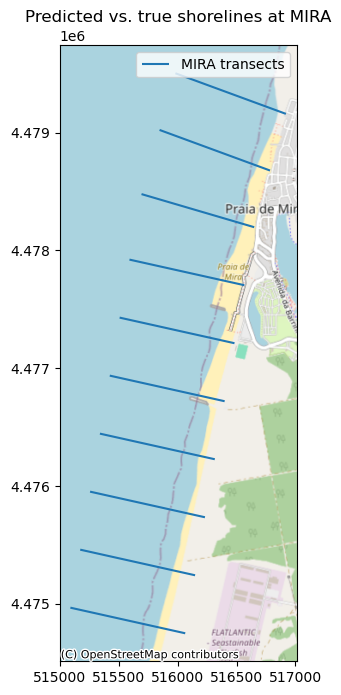

In [217]:
# Get unique beaches
beaches = transects_gdf['beach'].unique()

# Create a separate plot window for each beach
for beach in beaches:
    # Select transects for the current beach
    beach_transects = transects_gdf[transects_gdf['beach'] == beach]

    # Plot transects
    fig, ax = plt.subplots(figsize=(10, 8))
    beach_transects.plot(ax=ax, label=f'{beach} transects')

    # Add OpenStreetMap background using contextily
    ctx.add_basemap(ax, crs=beach_transects.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Set labels and legend
    ax.set_title(f'Predicted vs. true shorelines at {beach}')
    ax.legend()

    # Show the plot
    plt.show()

In [242]:
# Calculate and print the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

# Create a list to store the RMSE values
rmse_values = []

# Iterate through each unique site_name
for site_name in site_names:
    # Filter the DataFrame for the specific site_name
    y_test_site = y_test_df[y_test_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    y_pred_site = y_pred_df[y_pred_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    
    # Check if DataFrames are not empty before calculating RMSE
    if not y_test_site.empty and not y_pred_site.empty:
        # Calculate RMSE for the current site_name
        rmse = np.sqrt(mean_squared_error(y_test_site.values.flatten(), y_pred_site.values.flatten()))
        
        # Append the RMSE value to the list
        rmse_values.append({'site_name': site_name, 'rmse': rmse})

# Create a DataFrame from the list of RMSE values
rmse_df = pd.DataFrame(rmse_values)

# Display the RMSE DataFrame
print(rmse_df)

Root Mean Squared Error: 39.14892383925137
   site_name       rmse
0       CVCC  64.872253
1       CCFT  35.974723
2       FTAD  28.773530
3       ADLA  24.842805
4       LABI  26.656162
5       TRAT  43.840421
6       ATMC  21.691908
7       MCCO  27.282722
8       CCCL  17.503848
9       NNOR  33.176324
10      MEIA  31.133258
11      TORR  37.940954
12      CVMR  49.814787
13      MRMG  31.810114
14      MGVR  38.654669
15      COSN  40.578762
16      VAGR  39.298978
17      GBHA  51.002428
18      BARR  55.441468
19      MIRA  48.760859


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Naïve modelling

Dummy baseline that predicts the following year based on the previous one (equal)

In [221]:
# Splitting the combined data into training and testing sets - Naive model to compare

# Train for 2021
training_data_naive = combined_data_1[combined_data_1['years'] == 2021]

# Test for 2022
testing_data_naive = combined_data_1[combined_data_1['years'] == 2022]

# Define the columns for the target variables
target_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# Initialize an empty list to store dictionaries for naive predictions
naive_predictions = []

# Iterate over each beach and month, and use the 2021 value as the prediction for 2022
for beach in training_data_naive['beach'].unique():
    for month in range(1, 13):
        # Extract the last entry for the month in 2021 for the current beach
        last_entry = training_data_naive[(training_data_naive['beach'] == beach) & 
                                         (training_data_naive['months'] == month)][target_columns].iloc[-1]

        # Add the 'beach' and 'months' columns to last_entry for alignment with the test data
        last_entry['beach'] = beach
        last_entry['months'] = month

        # Append this entry to the predictions list
        naive_predictions.append(last_entry)

# Convert the list of dictionaries to a DataFrame
y_pred_naive = pd.DataFrame(naive_predictions)

# Align y_pred_naive with testing_data_naive
y_pred_naive = y_pred_naive.set_index(['beach', 'months'])
testing_data_naive = testing_data_naive.set_index(['beach', 'months'])
y_test_naive = testing_data_naive[target_columns]

## Evaluation metrics

In [241]:
# Calculate RMSE for the naive model
rmse_naive = mean_squared_error(y_test_naive, y_pred_naive, squared=False)
print("Root Mean Squared Error:", rmse_naive)

# Initialize an empty list to store the RMSE values
rmse_values = []

# Iterate through each unique site_name
for site_name in y_test_naive.index.get_level_values('beach').unique():
    # Filter the DataFrame for the specific site_name
    y_test_site = y_test_naive.loc[site_name]
    y_pred_site = y_pred_naive.loc[site_name]
    
    # Calculate the RMSE for the current site_name
    rmse = np.sqrt(mean_squared_error(y_test_site, y_pred_site))
    
    # Append the RMSE value to the list
    rmse_values.append({'site_name': site_name, 'rmse': rmse})

# Create a DataFrame from the list of RMSE values
rmse_df = pd.DataFrame(rmse_values)

# Display the RMSE DataFrame
print(rmse_df)


Root Mean Squared Error: 28.543021641743877
   site_name       rmse
0       CVCC  19.412584
1       CCFT  18.054068
2       FTAD   9.842635
3       ADLA  12.892315
4       LABI   9.788718
5       TRAT  11.776232
6       ATMC  25.603500
7       MCCO  26.606007
8       CCCL   8.711627
9       NNOR  17.145284
10      MEIA  15.497239
11      TORR  15.249676
12      CVMR  13.555523
13      MRMG  11.467413
14      MGVR  14.518223
15      COSN  18.544199
16      VAGR  25.146478
17      GBHA  21.169637
18      BARR  21.110853
19      MIRA  20.687824


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

# Second modelling attempt: Decision Tree Regression with time passage variable

In [225]:
# Feature Engineering - create a column that represents time passing
combined_data['elapsed_time'] = (combined_data['years'] - combined_data['years'].min()) * 12 + combined_data['months']

# Filter rows for training data (years <= 2014)
training_data_2 = combined_data[combined_data['years'] <= 2014]

# Filter rows for testing data (years > 2014)
testing_data_2 = combined_data[combined_data['years'] > 2014]

# Define the columns for the target variables
target_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# For training set
x_train_2 = training_data_2.drop(target_columns + ['years', 'months'], axis=1)
y_train_2 = training_data_2[target_columns]

# For testing set
x_test_2 = testing_data_2.drop(target_columns + ['years', 'months'], axis=1)
y_test_2 = testing_data_2[target_columns]

# Creating and training the model
model_2 = DecisionTreeRegressor(random_state=42)
model_2.fit(x_train_2, y_train_2)

# Making predictions and evaluating the model
y_pred_2 = model_2.predict(x_test_2)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

Root Mean Squared Error: 31.521402800152714


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Evaluation metrics

In [238]:
mse_2 = mean_squared_error(y_test_2, y_pred_2)
rmse_2 = mean_squared_error(y_test_2, y_pred_2, squared=False)

print("Root Mean Squared Error:", rmse_2)

y_pred_2_df = pd.DataFrame(y_pred_2, index=x_test_2.index)
y_pred_2_df.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# Ensure that the index of beach_names matches the index of y_pred_2_df
beach_names = combined_data_1['beach'].loc[x_test_2.index]

# Create a DataFrame with the actual and predicted values
y_pred_2_df['beach'] = beach_names.tolist()

y_test_2_df = pd.DataFrame(y_test_2)
y_test_2_df['beach'] = beach_names.tolist()

# Create a list to store the RMSE values
rmse_values = []

# Iterate through each unique site_name
for site_name in site_names:
    # Filter the DataFrame for the specific site_name
    y_test_2_site = y_test_2_df[y_test_2_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    y_pred_2_site = y_pred_2_df[y_pred_2_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    
    # Check if DataFrames are not empty before calculating RMSE
    if not y_test_2_site.empty and not y_pred_2_site.empty:
        # Calculate RMSE for the current site_name
        rmse_2 = np.sqrt(mean_squared_error(y_test_2_site.values.flatten(), y_pred_2_site.values.flatten()))
        
        # Append the RMSE value to the list
        rmse_values.append({'site_name': site_name, 'rmse': rmse_2})

# Create a DataFrame from the list of RMSE values
rmse_df_2 = pd.DataFrame(rmse_values)

# Display the RMSE DataFrame
print(rmse_df_2)

Root Mean Squared Error: 31.521402800152714
   site_name       rmse
0       CVCC  31.494866
1       CCFT  32.791620
2       FTAD  26.002347
3       ADLA  19.880822
4       LABI  23.923726
5       TRAT  26.862199
6       ATMC  21.841195
7       MCCO  21.678594
8       CCCL  16.359970
9       NNOR  37.276672
10      MEIA  23.021520
11      TORR  36.090138
12      CVMR  35.556956
13      MRMG  22.187262
14      MGVR  66.995766
15      COSN  33.543412
16      VAGR  28.373346
17      GBHA  34.534582
18      BARR  28.749567
19      MIRA  31.683787


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

# Third modelling attempt: Random Forest Model

In [229]:
# Creating and training the Random Forest model
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(x_train_2, y_train_2)

# Making predictions and evaluating the model
y_pred_rf = model_rf.predict(x_test_2)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

Root Mean Squared Error with Random Forest: 18.687741452744138


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Evaluation metrics

In [237]:
mse_rf = mean_squared_error(y_test_2, y_pred_rf)
rmse_rf = mean_squared_error(y_test_2, y_pred_rf, squared=False)

print("Root Mean Squared Error with Random Forest:", rmse_rf)

y_pred_rf_df = pd.DataFrame(y_pred_rf, index=x_test_2.index)
y_pred_rf_df.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# Ensure that the index of beach_names matches the index of y_pred_2_df
beach_names = combined_data_1['beach'].loc[x_test_2.index]

# Create a DataFrame with the actual and predicted values
y_pred_rf_df['beach'] = beach_names.tolist()

y_test_2_df = pd.DataFrame(y_test_2)
y_test_2_df['beach'] = beach_names.tolist()

# Create a list to store the RMSE values
rmse_values = []

# Iterate through each unique site_name
for site_name in site_names:
    # Filter the DataFrame for the specific site_name
    y_test_2_site = y_test_2_df[y_test_2_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    y_pred_rf_df_site = y_pred_rf_df[y_pred_rf_df['beach'] == site_name].drop('beach', axis=1)  # Exclude 'beach' column
    
    # Check if DataFrames are not empty before calculating RMSE
    if not y_test_2_site.empty and not y_pred_rf_df_site.empty:
        # Calculate RMSE for the current site_name
        rmse_2 = np.sqrt(mean_squared_error(y_test_2_site.values.flatten(), y_pred_rf_df_site.values.flatten()))
        
        # Append the RMSE value to the list
        rmse_values.append({'site_name': site_name, 'rmse': rmse_2})

# Create a DataFrame from the list of RMSE values
rmse_df_2 = pd.DataFrame(rmse_values)

# Display the RMSE DataFrame
print(rmse_df_2)

Root Mean Squared Error with Random Forest: 18.687741452744138
   site_name       rmse
0       CVCC  24.306133
1       CCFT  24.853867
2       FTAD  16.577309
3       ADLA  11.741779
4       LABI  11.972424
5       TRAT  17.129918
6       ATMC  15.227338
7       MCCO  15.441430
8       CCCL   8.977495
9       NNOR  19.503547
10      MEIA  16.180605
11      TORR  17.568663
12      CVMR  24.035128
13      MRMG  13.574078
14      MGVR  21.541610
15      COSN  20.237283
16      VAGR  17.655097
17      GBHA  24.420776
18      BARR  21.071637
19      MIRA  21.932031


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

## Time series cross-validation 

This ensures that each test set is 'ahead in time' relative to its corresponding training set, thereby better mimicking the scenario where you predict future values based on past observations. 
This method provides a more robust and realistic evaluation of your model's performance over time.

In [236]:
# Define the columns for the target variables and features
target_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9','P10']
feature_columns = [col for col in combined_data.columns if col not in target_columns + ['years', 'months']]

# Preparing the dataset
X = combined_data[feature_columns]
y = combined_data[target_columns]

# Create time series cross-validator object
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store results
rmse_scores = []

# Loop through each split
for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Create and fit the Random Forest model
    model_cv = RandomForestRegressor(random_state=42)
    model_cv.fit(X_train_cv, y_train_cv)

    # Make predictions and evaluate
    y_pred_cv = model_cv.predict(X_test_cv)
    rmse_cv = mean_squared_error(y_test_cv, y_pred_cv, squared=False)
    rmse_scores.append(rmse_cv)

# Calculate average RMSE
average_rmse = np.mean(rmse_scores)
print("Average RMSE with Time Series Cross-Validation:", average_rmse)

c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

Average RMSE with Time Series Cross-Validation: 24.77126033463984


c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\danie\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i